# Deep Learning Assignment - 10
# Name: Sahana Thoravalli Prabhuswamy
# Student ID: 016796832
# Github link for assignments:
https://github.com/SahanaTP/DeepLearningAssignments

#Download SQuAD 2.0 dataset and required libraries

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 13.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.0/774.0 kB 12.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 15.2 MB/s eta 0:00:00a 0:00:01


In [ ]:
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 17.2 MB/s eta 0:00:00


In [1]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForQuestionAnswering
import time

In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


* The Stanford Question Answering Dataset (SQuAD) consists of questions (100,000) on a set of Wikipedia articles where the answer to every question is a segment of text, or span, from the corresponding reading passage.

* In second version of SQuAD unanswerable questions were added (50,000) to look similar to answerable ones.

* The purpose of systems using the SQuAD2.0 dataset, must be not only answer questions when possible, but also determine when no answer is supported by the paragraph and abstain from answering.

In [4]:
import urllib.request

def download_file(url, file_path):
    urllib.request.urlretrieve(url, file_path)

# Example usage:
train_data_url = 'https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json'
dev_data_url = 'https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json'
train_file_path = 'train.json'
test_file_path = 'test.json'
download_file(train_data_url, train_file_path)
download_file(dev_data_url, test_file_path)

# Retrieve and Store the data

Here I take and store the texts, queries and answers from the train and validation .json files. If we look carefully we will see that in these files there are a number of queries and answers for each passage. I save these informations into lists.

In [6]:
# Define the path to the SQuAD 2.0 training data
path = "train.json"

# Load and preprocess the SQuAD 2.0 data
def load_squad_data(path):
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    texts = []
    questions = []
    answers = []

    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    texts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return texts, questions, answers

# Preprocess the data to find answer start and end positions
train_texts, train_queries, train_answers = load_squad_data(path)

In [7]:
# Give the path for SQuAD 2.0 validation data
path = Path('test.json')

# Load and preprocess the SQuAD 2.0 data
def load_squad_data(path):
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    texts = []
    questions = []
    answers = []

    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    texts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return texts, questions, answers

# Preprocess the data to find answer start and end positions
val_texts, val_queries, val_answers = load_squad_data(path)

# Check and display some sample data

In [ ]:
print(len(train_texts))
print(len(train_queries))
print(len(train_answers))

86821
86821
86821


In [ ]:
print("Passage: ",train_texts[0])
print("Query: ",train_queries[0])
print("Answer: ",train_answers[0])

Passage:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Query:  When did Beyonce start becoming popular?
Answer:  {'text': 'in the late 1990s', 'answer_start': 269}


In [ ]:
print("Passage: ",train_texts[1])
print("Query: ",train_queries[1])
print("Answer: ",train_answers[1])

Passage:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Query:  What areas did Beyonce compete in when she was growing up?
Answer:  {'text': 'singing and dancing', 'answer_start': 207}


In [ ]:
print(len(val_texts))
print(len(val_queries))
print(len(val_answers))

20302
20302
20302


In [ ]:
print("Passage: ",val_texts[0])
print("Query: ",val_queries[0])
print("Answer: ",val_answers[0])

Passage:  The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Query:  In what country is Normandy located?
Answer:  {'text': 'France', 'answer_start': 159}


# Find the start and end position character of the real answer from the passages

In [ ]:
for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1
    # When the real answer is more by two characters
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2

In [ ]:
for answer, text in zip(val_answers, val_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1
    # When the real answer is more by two characters
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2


# Tokenize passages and queries

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, val_queries, truncation=True, padding=True)

# Convert the start-end positions to tokens start-end positions

In [ ]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []

    count = 0

    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length

        # if end position is None, the 'char_to_token' function points to the space after the correct token, so add - 1
        if end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)

            # if end position is still None the answer passage has been truncated
            if end_positions[-1] is None:
                count += 1
                end_positions[-1] = tokenizer.model_max_length
    print(count)

    # Update the data in dictionary
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

10
16


It was observed that after tokenize the end position character, sometimes was still None. This happended only for 10 answers in train data (of total 86821) and 16 answers in validation data (of total 20302).

So It was decided to move the answer 1 position left. If it was still None then it was given the model_max_length as before.

I have to refer that I was trying to see if the answers in this case was 1 postition after (so I added +1 to the end position) or 2 positions left or right (+/- 2 positions), but the answers that there are still None was more (ie 526, while with this code there only 10).

So I kept this strategy in the end, in order to have as less as possible "burned" answers.

# Create a Dataset class

In [ ]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

# Move data to a DataLoader

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

# Build the Bert model

* BertForQuestionAnswering from transformers library was selected.

* When we instantiate a model with from_pretrained(), the model configuration and pre-trained weights of the specified model are used to initialize the model.

* Moreover, I have used the PyTorch optimizer of AdamW which implements gradient bias correction as well as weight decay.

In [ ]:
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import AdamW
optim = AdamW(model.parameters(), lr=5e-5)

epochs = 3

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Train and Evaluate Model

In [ ]:
whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 1000

for epoch in range(epochs):
    epoch_time = time.time()

    # Set model in train mode
    model.train()
    loss_of_epoch = 0

    print("############Train############")

    for batch_idx,batch in enumerate(train_loader):
        optim.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        # do a backwards pass
        loss.backward()
        # update the weights
        optim.step()
        # Find the total loss
        loss_of_epoch += loss.item()

        if (batch_idx+1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")

    loss_of_epoch /= len(train_loader)
    train_losses.append(loss_of_epoch)

    ##########Evaluation##################

    # Set model in evaluation mode
    model.eval()

    print("############Evaluate############")

    loss_of_epoch = 0

    for batch_idx,batch in enumerate(val_loader):

        with torch.no_grad():

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            loss = outputs[0]
            # Find the total loss
            loss_of_epoch += loss.item()

        if (batch_idx+1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx+1,len(val_loader)),"\nLoss:", round(loss.item(),1),"\n")

    loss_of_epoch /= len(val_loader)
    val_losses.append(loss_of_epoch)

    # Print each epoch's time and train/val loss

    print("\n-------Epoch ", epoch+1,
          "-------"
          "\nTraining Loss:", train_losses[-1],
          "\nValidation Loss:", val_losses[-1],
          "\nTime: ",(time.time() - epoch_time),
          "\n-----------------------",
          "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
Batch 1000 / 10853 
Loss: 1.6 

Batch 2000 / 10853 
Loss: 1.1 

Batch 3000 / 10853 
Loss: 1.1 

Batch 4000 / 10853 
Loss: 0.9 

Batch 5000 / 10853 
Loss: 1.1 

Batch 6000 / 10853 
Loss: 0.8 

Batch 7000 / 10853 
Loss: 1.3 

Batch 8000 / 10853 
Loss: 0.9 

Batch 9000 / 10853 
Loss: 0.9 

Batch 10000 / 10853 
Loss: 1.7 

############Evaluate############
Batch 1000 / 2538 
Loss: 1.7 

Batch 2000 / 2538 
Loss: 1.2 


-------Epoch  1 -------
Training Loss: 1.338770088788349 
Validation Loss: 1.1537410005386934 
Time:  1288.947919845581 
----------------------- 


############Train############
Batch 1000 / 10853 
Loss: 1.0 

Batch 2000 / 10853 
Loss: 0.4 

Batch 3000 / 10853 
Loss: 1.1 

Batch 4000 / 10853 
Loss: 0.5 

Batch 5000 / 10853 
Loss: 0.4 

Batch 6000 / 10853 
Loss: 0.7 

Batch 7000 / 10853 
Loss: 0.2 

Batch 8000 / 10853 
Loss: 0.9 

Batch 9000 / 10853 
Loss: 0.4 

Batch 10000 / 10853 
Loss: 1.0 

############Evaluate############
Batch 1000 / 2538 
Lo

# Plot for train and validation losses

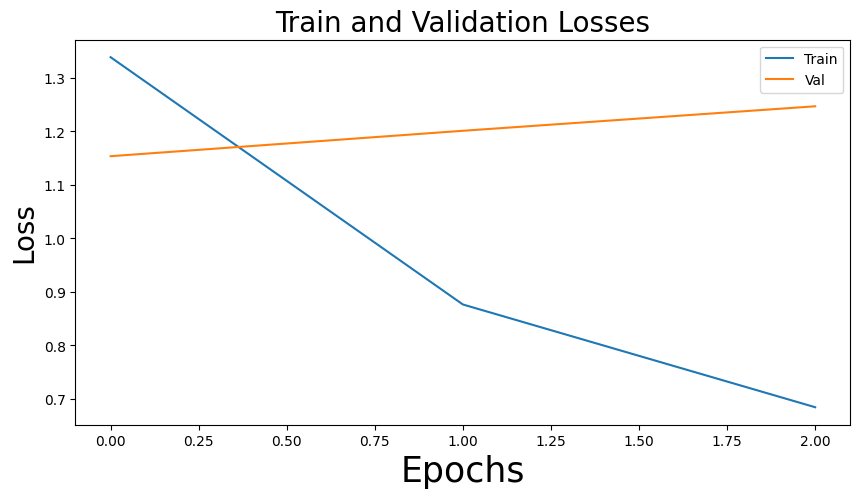

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20)
ax.set_xlabel('Epochs', fontsize = 25)
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')

# Save trained model

In [ ]:
# Save model to Google Drive
torch.save(model, 'bert_qa_model.pt')

# Load trained model

In [ ]:
bert_model2 = torch.load('bert_qa_model.pt',map_location=torch.device('cpu'))
bert_model2.eval()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

# Make the prediction and evaluate it

In [ ]:
def predict(context,query):

    inputs = tokenizer.encode_plus(query, context, return_tensors='pt')
    outputs = bert_model2(**inputs)
    answer_start = torch.argmax(outputs[0])  # get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(outputs[1]) + 1
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
    return answer

def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()

    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)

    common_tokens = set(pred_tokens) & set(truth_tokens)

    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0

    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    return 2 * (prec * rec) / (prec + rec)

In [ ]:
def give_an_answer(context,query,answer):
    prediction = predict(context,query)
    em_score = compute_exact_match(prediction, answer)
    f1_score = compute_f1(prediction, answer)
    print(f"Question: {query}")
    print(f"Prediction: {prediction}")
    print(f"True Answer: {answer}")
    print(f"EM: {em_score}")
    print(f"F1: {f1_score}")
    print("\n")

# Test the trained model

Here I give some examples to my trained BERT model on SQuAD 2.0 dataset to see how well I trained it. I started with more easier examples and then I gave it more complex ones.

For extractive textual QA tasks, we usually adopt two evaluation metrics, which measure ***exact match*** and partially ***overlapped scores*** respectively.

***Exact Match***: measures whether the predicted answer exactly matches the ground-truth answers. If the exact matching occurs, then assigns 1.0, otherwise assigns 0.0.

***F1 Score***: computes the average word overlap between predicted and ground-truth answers, which can ensure both of precision and recall rate are optimized at the same time.

**As you can see my model predicted all the answers correct in a very small an easy example.**

In [ ]:
context = "Hi! My name is Sahana and I am 29 years old. I used to live in Mysore of India, but now I moved to California of USA."

queries = ["How old is Sahana?",
           "Where does Sahana live now?",
           "Where Sahana used to live?"
          ]
answers = ["29",
           "Mysore of India",
           "California of USA"
          ]

for q,a in zip(queries,answers):
    give_an_answer(context,q,a)


Question: How old is Sahana?
Prediction: 29 years old.
True Answer: 29
EM: 0
F1: 0.5


Question: Where does Sahana live now?
Prediction: mysore of india,
True Answer: Mysore of India
EM: 1
F1: 1.0


Question: Where Sahana used to live?
Prediction: mysore of india,
True Answer: California of USA
EM: 0
F1: 0.3333333333333333




In [ ]:
context = """ Queen are a British rock band formed in London in 1970. Their classic line-up was Freddie Mercury (lead vocals, piano),
            Brian May (guitar, vocals), Roger Taylor (drums, vocals) and John Deacon (bass). Their earliest works were influenced
            by progressive rock, hard rock and heavy metal, but the band gradually ventured into more conventional and radio-friendly
            works by incorporating further styles, such as arena rock and pop rock. """

queries = ["When did Queen found?",
           "Who were the basic members of Queen band?",
           "What kind of band they are?"
          ]
answers = ["1970",
           "Freddie Mercury, Brian May, Roger Taylor and John Deacon",
           "rock"
          ]

for q,a in zip(queries,answers):
    give_an_answer(context,q,a)

Question: When did Queen found?
Prediction: 1970.
True Answer: 1970
EM: 1
F1: 1.0


Question: Who were the basic members of Queen band?
Prediction: freddie mercury ( lead vocals, piano ), brian may ( guitar, vocals ), roger taylor ( drums, vocals ) and john deacon ( bass ).
True Answer: Freddie Mercury, Brian May, Roger Taylor and John Deacon
EM: 0
F1: 0.6923076923076924


Question: What kind of band they are?
Prediction: rock
True Answer: rock
EM: 1
F1: 1.0




In [ ]:
context = """ Mount Olympus is the highest mountain in Greece. It is part of the Olympus massif near
              the Gulf of Thérmai of the Aegean Sea, located in the Olympus Range on the border between
              Thessaly and Macedonia, between the regional units of Pieria and Larissa, about 80 km (50 mi)
              southwest from Thessaloniki. Mount Olympus has 52 peaks and deep gorges. The highest peak,
              Mytikas, meaning "nose", rises to 2917 metres (9,570 ft). It is one of the
              highest peaks in Europe in terms of topographic prominence. """

queries = [
           "How many metres is Olympus?",
           "Where Olympus is near?",
           "How far away is Olympus from Thessaloniki?"
          ]
answers = [
           "2917",
           "Gulf of Thérmai of the Aegean Sea",
           "80 km (50 mi)"
          ]

for q,a in zip(queries,answers):
    give_an_answer(context,q,a)

Question: How many metres is Olympus?
Prediction: 2917
True Answer: 2917
EM: 1
F1: 1.0


Question: Where Olympus is near?
Prediction: gulf of thermai of the aegean sea,
True Answer: Gulf of Thérmai of the Aegean Sea
EM: 0
F1: 0.6666666666666666


Question: How far away is Olympus from Thessaloniki?
Prediction: 80 km
True Answer: 80 km (50 mi)
EM: 0
F1: 0.6666666666666666




In [ ]:
context = """ The COVID-19 pandemic, also known as the coronavirus pandemic, is an ongoing pandemic of coronavirus disease 2019 (COVID-19)
              caused by severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). It was first identified in December 2019 in Wuhan, China.
              The World Health Organization declared the outbreak a Public Health Emergency of International Concern in January 2020 and a pandemic
              in March 2020. As of 6 February 2021, more than 105 million cases have been confirmed, with more than 2.3 million deaths attributed to COVID-19.
              Symptoms of COVID-19 are highly variable, ranging from none to severe illness. The virus spreads mainly through the air when people are
              near each other.[b] It leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes.
              It may also spread via contaminated surfaces. People remain infectious for up to two weeks, and can spread the virus even if they do not show symptoms.[9]"""

queries = [
           "What is COVID-19?",
           "What is caused by COVID-19?",
           "How many cases have been confirmed from COVID-19?",
           "How many deaths have been confirmed from COVID-19?",
           "How is COVID-19 spread?",
           "How long can an infected person remain infected?",
           "Can a infected person spread the virus even if they don't have symptoms?",
           "What do elephants eat?"
          ]
answers = [
           "an ongoing pandemic of coronavirus disease 2019",
           "severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2)",
           "more than 105 million cases",
           "more than 2.3 million deaths",
           "mainly through the air when people are near each other. It leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes. It may also spread via contaminated surfaces.",
           "up to two weeks",
           "yes",
           " "
          ]

for q,a in zip(queries,answers):
      give_an_answer(context,q,a)

Question: What is COVID-19?
Prediction: coronavirus disease 2019
True Answer: an ongoing pandemic of coronavirus disease 2019
EM: 0
F1: 0.6666666666666666


Question: What is caused by COVID-19?
Prediction: coronavirus disease 2019 ( covid - 19 ) caused by severe acute respiratory syndrome coronavirus 2 ( sars - cov - 2 ). it was first identified in december 2019 in wuhan, china. the world health organization declared the outbreak a public health emergency of international concern in january 2020 and a pandemic in march 2020. as of 6 february 2021, more than 105 million cases have been confirmed, with more than 2. 3 million deaths attributed to covid - 19. symptoms of covid - 19 are highly variable, ranging from none to severe illness. the virus spreads mainly through the air when people are near each other. [ b ] it leaves an infected person as they breathe, cough, sneeze, or speak and enters another person via their mouth, nose, or eyes.
True Answer: severe acute respiratory syndrome

In [ ]:
context = """ Harry Potter is a series of seven fantasy novels written by British author, J. K. Rowling. The novels chronicle the lives of a young wizard,
              Harry Potter, and his friends Hermione Granger and Ron Weasley, all of whom are students at Hogwarts School of Witchcraft and Wizardry.
              The main story arc concerns Harry's struggle against Lord Voldemort, a dark wizard who intends to become immortal, overthrow the wizard
              governing body known as the Ministry of Magic and subjugate all wizards and Muggles (non-magical people). Since the release of the first novel,
              Harry Potter and the Philosopher's Stone, on 26 June 1997, the books have found immense popularity, positive reviews, and commercial success worldwide.
              They have attracted a wide adult audience as well as younger readers and are often considered cornerstones of modern young adult literature.[2]
              As of February 2018, the books have sold more than 500 million copies worldwide, making them the best-selling book series in history, and have been translated
              into eighty languages.[3] The last four books consecutively set records as the fastest-selling books in history, with the final installment selling roughly
              eleven million copies in the United States within twenty-four hours of its release.  """

queries = [
           "Who wrote Harry Potter's novels?",
           "Who are Harry Potter's friends?",
           "Who is the enemy of Harry Potter?",
           "What are Muggles?",
           "Which is the name of Harry Poter's first novel?",
           "When did the first novel release?",
           "Who was attracted by Harry Potter novels?",
           "How many languages Harry Potter has been translated into? "
          ]
answers = [
           "J. K. Rowling",
           "Hermione Granger and Ron Weasley",
           "Lord Voldemort",
           "non-magical people",
           "Harry Potter and the Philosopher's Stone",
           "26 June 1997",
           "a wide adult audience as well as younger readers",
           "eighty"
          ]

for q,a in zip(queries,answers):
      give_an_answer(context,q,a)

Question: Who wrote Harry Potter's novels?
Prediction: j. k. rowling.
True Answer: J. K. Rowling
EM: 1
F1: 1.0


Question: Who are Harry Potter's friends?
Prediction: hermione granger and ron weasley,
True Answer: Hermione Granger and Ron Weasley
EM: 1
F1: 1.0


Question: Who is the enemy of Harry Potter?
Prediction: lord voldemort,
True Answer: Lord Voldemort
EM: 1
F1: 1.0


Question: What are Muggles?
Prediction: non - magical people )
True Answer: non-magical people
EM: 0
F1: 0.4


Question: Which is the name of Harry Poter's first novel?
Prediction: 
True Answer: Harry Potter and the Philosopher's Stone
EM: 0
F1: 0


Question: When did the first novel release?
Prediction: 26 june 1997,
True Answer: 26 June 1997
EM: 1
F1: 1.0


Question: Who was attracted by Harry Potter novels?
Prediction: j. k. rowling.
True Answer: a wide adult audience as well as younger readers
EM: 0
F1: 0


Question: How many languages Harry Potter has been translated into? 
Prediction: seven
True Answer: eigh

# Summary

* In general that in questions that included words or phrases from the paragraph the model went perfectly.

* Sometimes when the question is more complicated or not so well-structured the model had very descent results.
* Given the fact that the model was trained only with three epochs and it has a very good performance.